In [46]:
import os 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

from data_exploration import *

# Initial Data Exploration

The following code explores the data splits of Goldman et al. (2022), looking at relationships between feature set overlap, training size, and other properties. 

In [47]:
def plot_stats(x, y, xlab, ylab, savefig=None, less=False):
    """Helper function to make the plots aesthetic and run stats"""
    
    # Convert the input to arrays so we can get a line of best fit 
    if less:
        x, y = overlap_less(x, y)
    x = np.asarray(x)
    y = np.asarray(y)
    a, b = np.polyfit(x, y, 1)
    
    # Plot the points and the line of best fit 
    plt.clf()
    plt.scatter(x, y, color="indigo", alpha=0.2, s=70)
    plt.plot(x, a*x+b, linestyle="-", color="indigo", linewidth=1)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"{ylab} vs. {xlab}")
    if savefig is None:
        plt.show()
    else:
        plt.savefig(savefig, dpi=500)
    
    # Run the statistics 
    pearson = stats.pearsonr(x, y)
    spearman = stats.spearmanr(x, y)
    kendall_tau = stats.kendalltau(x, y)
    for name, stat in [("Pearson's R", pearson), ("Spearman", spearman), ("Kendall's Tau", kendall_tau)]:
        print(f"{name}:\t{stat.statistic :.3f},\t p = {stat.pvalue}")

def run_correlation(PATH_TO_DATA, funct1, funct2):
    """Run a single correlation between two functions over the data"""
    xs = []
    ys = []
    langs = []
    for language_family in [l for l in os.listdir(PATH_TO_DATA) if "." not in l]:
        for language in set([f.split(".")[0] for f in os.listdir(f"{PATH_TO_DATA}/{language_family}")]):
            xs.append(funct1(f"{PATH_TO_DATA}/{language_family}/{language}"))
            ys.append(funct2(f"{PATH_TO_DATA}/{language_family}/{language}"))
            langs.append(f"{language_family}/{language}")
    return xs, ys, langs

## Featureset Overlap

The following shows the relationship between full featureset overlap and training size in the Goldman data. 
There seems to be little relationship, and as expected based on the splitting methodology most of the languages have 100% feature overlap. 
However, there are several outliers, the most notable of which is Ludic, with a feature overlap of just 0.303.

Pearson's R:	0.068,	 p = 0.5214148242235089
Spearman:	-0.254,	 p = 0.015637164504902358
Kendall's Tau:	-0.207,	 p = 0.014535193521698355


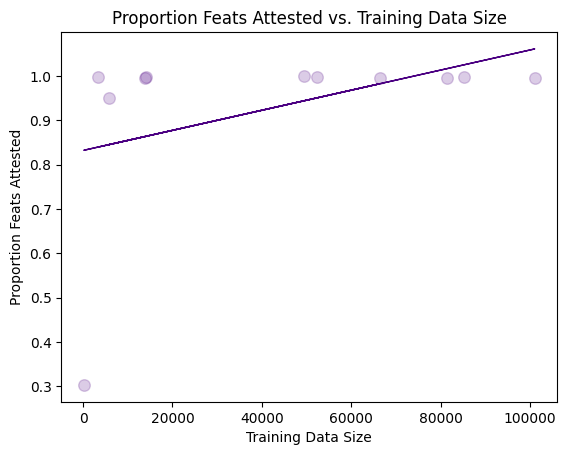

Pearson's R:	0.404,	 p = 0.21767785564154674
Spearman:	0.127,	 p = 0.7092146257733047
Kendall's Tau:	0.091,	 p = 0.7611503928170594


In [49]:
PATH_TO_DATA = "LemmaSplitting/LemmaSplitData"

# Get the feature overlap and train sizes
trn_sz, overlap, languages = run_correlation(PATH_TO_DATA, train_size, feature_overlap)

# Plot all
plot_stats(trn_sz, 
           overlap, 
           "Training Data Size", 
           "Proportion Feats Attested", 
           savefig="../writeup/figs/feats_attested.png")

# Plot just those that have overlap < 100%
plot_stats(trn_sz, 
           overlap, 
           "Training Data Size", 
           "Proportion Feats Attested", 
           less=True)

Clearly, if we are splitting my lemmas and have complete paradigms, we _should_ (except in cases of gaps, but even then sufficient data should remedy this) have 100% feature overlap at all times. 
However, the graph above clearly demonstrates that this is not the case. 
We thus investigate the causes of overlap being less than 100%. 

### Train vs. Test Paradigm Size 
Initial exploration shows that dips in overlap are usually caused by a few lemmas in test that appear in _much_ bigger paradigms than words of the same part of speech in train. 
To quantify this, we measure for each part of speech the mean paradigm size for the `training` (train + dev) data, the `test` data, and the `problematic lemmas` in the test data, which are defined as any lemma in the test data that occurs with at least one feature set not attested in train. 

In [8]:
# Iterate over the languages with less than 100% overlap and examine paradigm sizes for each 
for ovlp, lang in zip(overlap, languages):
    if ovlp < 1:
        print(lang, ovlp)
        investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}")

romance/vec 0.9960362400906002
POS: V
	 mean train paradigm size:	 47.282, (stdev: 4.185, n = 294, max = 57)
	 mean test paradigm size:	 47.730, (stdev: 3.214, n = 74)
	 mean problematic lemma size:	 54.000, (stdev: 7.000, n = 2)


tungusic/evn 0.9501404494382022
POS: N
	 mean train paradigm size:	 1.717, (stdev: 2.190, n = 1859, max = 34)
	 mean test paradigm size:	 1.684, (stdev: 2.191, n = 437)
	 mean problematic lemma size:	 6.000, (stdev: 8.116, n = 15)


POS: V
	 mean train paradigm size:	 2.345, (stdev: 3.881, n = 797, max = 42)
	 mean test paradigm size:	 2.567, (stdev: 5.496, n = 201)
	 mean problematic lemma size:	 6.742, (stdev: 11.862, n = 31)


POS: ADJ
	 mean train paradigm size:	 1.192, (stdev: 0.789, n = 308, max = 11)
	 mean test paradigm size:	 1.066, (stdev: 0.248, n = 91)
	 mean problematic lemma size:	 1.200, (stdev: 0.400, n = 5)


germanic/nob 0.9985689753863767
POS: ADJ
	 mean train paradigm size:	 2.402, (stdev: 1.004, n = 667, max = 5)
	 mean test paradigm siz

### Quantifying the Difference for Problematic Lemmas 
We can see above that the mean paradigm size for `problematic lemmas` is generally higher than the mean paradigm size for the same POS in train. 
We quantify this in terms of _percent increase_ from the paradigm size in train to the paradigm size for problematic lemmas in test: $\frac{\texttt{average problematic paradigm size} - \texttt{average train paradigm size}}{\texttt{average train paradigm size}}$ for each part of speech in each language.
As a point of comparison, we also measure the percent increase from the average training paradigm size to the _maximum paradigm size_ for the same POS in test for all languages with 100\% feature overlap.
We find a significant difference, measured quantitatively and visualized below.

Problematic difference: 	mean: 482.450 (stdev: 894.829)
Max difference: 	mean: 11.941 (stdev: 33.216)
T-test:	 5.801 (p: 3.708933370244296e-08)


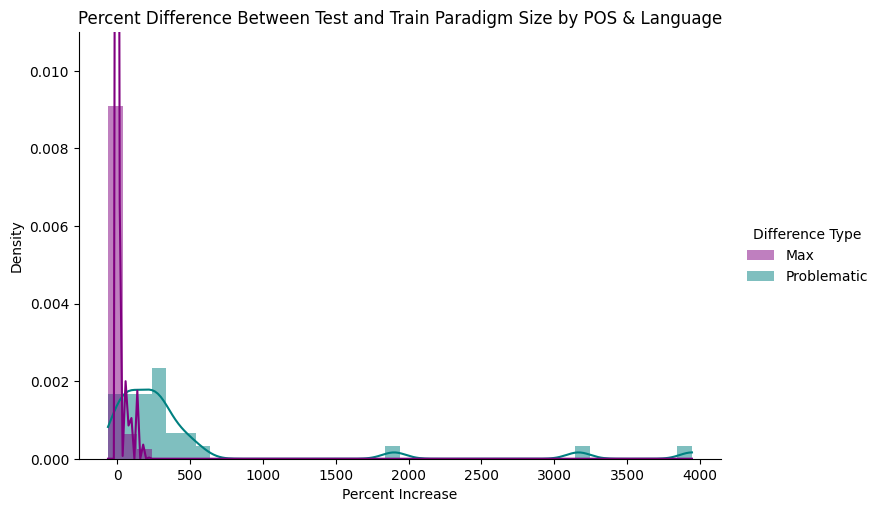

In [9]:
# We'll store the differences and the type of differences in two lists 
differences = []
labels = []

for ovlp, lang in zip(overlap, languages):
    # This gives a dictionary with the mean, stdev, and max paradigm size for train, test, and problematic lemmas
    res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
    # Examine each POS for each language 
    for pos in res:
        label = ""
        # If there's not 100% overlap, measure the difference between the average problematic & train paradigm size
        if ovlp < 1:
            if "problematic" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                label = "Problematic"
        # If there is 100% overlap, measure the difference between the max & train paradigm size 
        else:
            if "test" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["test"][-1]
                label = "Max"
        # If we found one of the above, append the percent increase and label to the list 
        if label:
            difference = 100 * (test - train) / train
            differences.append(difference)
            labels.append(label)
    

# Create a DF for plotting, plot it, and save the plot 
df = pd.DataFrame({"Difference Type": labels, "Percent Increase": differences})
sns.displot(df, 
            palette=["purple", "teal"], 
            linewidth=0, 
            alpha=0.5, 
            x="Percent Increase", 
            hue="Difference Type", 
            kde=True, 
            kde_kws={"bw_method": 0.3, "bw_adjust": 0.3}, 
            binwidth=100, 
            common_norm=False, 
            stat="density",
            aspect=1.5
           )
plt.ylim(0.0, 0.011)
plt.title("Percent Difference Between Test and Train Paradigm Size by POS & Language")
plt.savefig("../writeup/figs/percent_increase.png", dpi=500, bbox_inches='tight')


# Now, we run some stats over the problematic and max data
difference_problematic = df.loc[df['Difference Type'] == "Problematic"]
difference_max = df.loc[df['Difference Type'] == "Max"]

# Get the mean and standard deviation in percent increase
for data in [difference_problematic, difference_max]:
    label = list(data["Difference Type"])[0]
    data = data["Percent Increase"]
    print(f"{label} difference: \tmean: {np.average(data):.3f} (stdev: {np.std(data):.3f})")

# Run an unpaired t-test 
ttest = stats.ttest_ind(difference_problematic["Percent Increase"], difference_max["Percent Increase"])
print(f"T-test:\t {ttest.statistic :.3f} (p: {ttest.pvalue})")

### Relationship Between These Measures and Overlap

Below, we consider the relationship between percent increase from train to problematic lemmas vs. the featureset overlap between test and train.
We also consider the standard deviation in the paradigm size of the problematic lemmas as well as for _all_ lemmas of the given POS in test. 
Each POS for each language represents a unique point.

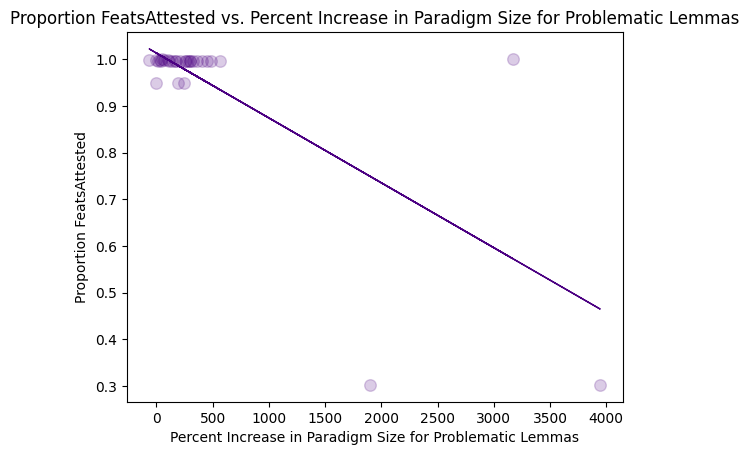

Pearson's R:	-0.720,	 p = 7.1632869623675314e-06
Spearman:	-0.357,	 p = 0.05280883101812484
Kendall's Tau:	-0.279,	 p = 0.03557771867026129


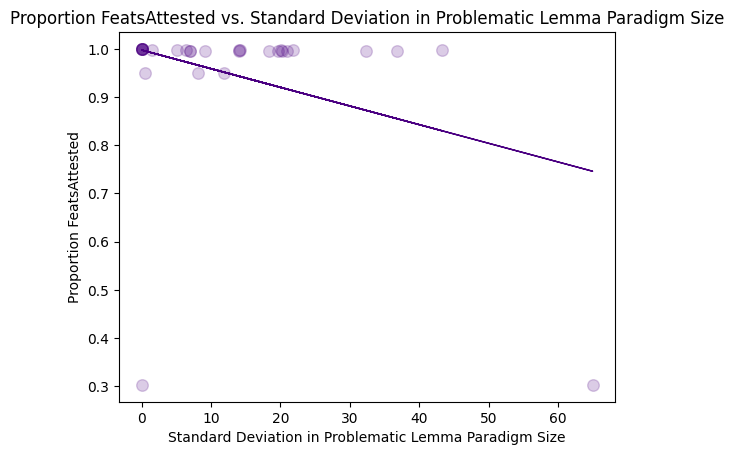

Pearson's R:	-0.336,	 p = 0.0694061530420374
Spearman:	-0.459,	 p = 0.010693644901103468
Kendall's Tau:	-0.339,	 p = 0.01288892440648635


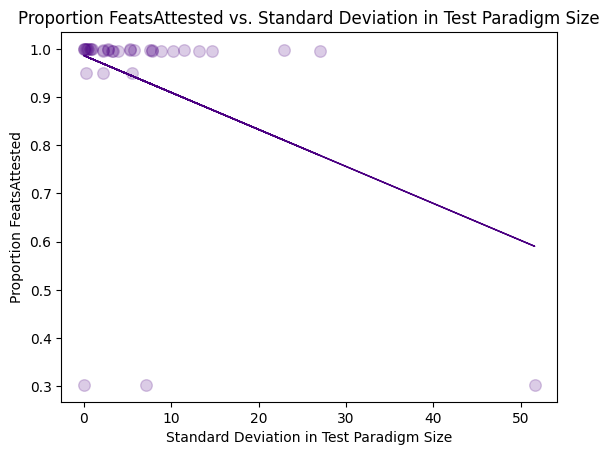

Pearson's R:	-0.391,	 p = 0.020191004732304726
Spearman:	-0.415,	 p = 0.013278849111123526
Kendall's Tau:	-0.313,	 p = 0.01053945191108583


In [10]:
ovlps_problematic = []
ovlps_test = []
problematic_percent_increase = []
problematic_stdevs = []
test_stdevs = []

# Iterate through all the languages with less than 100% overlap and store each POS separately 
for ovlp, lang in zip(overlap, languages):
    res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
    if ovlp < 1: 
        for pos in res:
            if "problematic" in res[pos]:
                # Percent increase in paradigm size 
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                diff = 100 * (test - train) / train 
                problematic_percent_increase.append(diff)
                # Standard deviation in problematic paradigm size 
                problematic_stdevs.append(res[pos]["problematic"][1])
                ovlps_problematic.append(ovlp)
            if "test" in res[pos]:
                # Standard deviation in test paradigm size 
                test_stdevs.append(res[pos]["test"][1])
                ovlps_test.append(ovlp)

# Plot the percent increase vs. the featureset overlap 
plot_stats(problematic_percent_increase, 
           ovlps_problematic, 
           "Percent Increase in Paradigm Size for Problematic Lemmas", 
           "Proportion FeatsAttested")

# Plot the standard deviation vs. the featureset overlap 
plot_stats(problematic_stdevs,
           ovlps_problematic, 
           "Standard Deviation in Problematic Lemma Paradigm Size", 
           "Proportion FeatsAttested")

# Plot the standard deviation of the test paradigm size vs. the featureset overlap 
plot_stats(test_stdevs, 
           ovlps_test, 
           "Standard Deviation in Test Paradigm Size", 
           "Proportion FeatsAttested")    

We run the same as above, except now each point on the plot corresponds to a single language, and represents the average of the given measure across all POS in that language. 

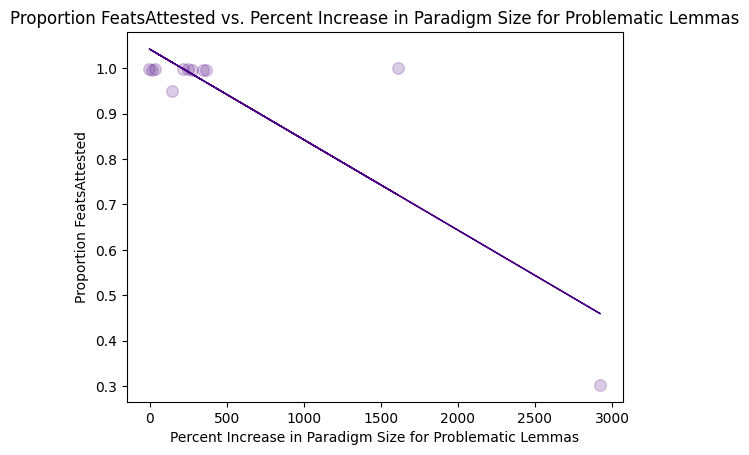

Pearson's R:	-0.861,	 p = 0.0006651770382294052
Spearman:	-0.236,	 p = 0.4840911622253965
Kendall's Tau:	-0.200,	 p = 0.4453821448613115


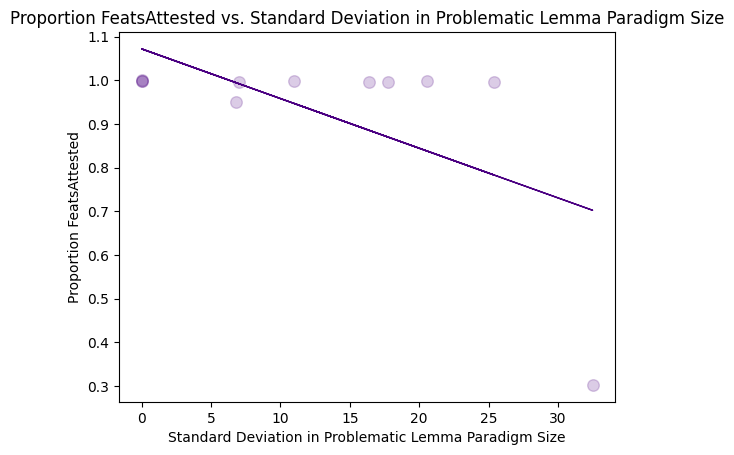

Pearson's R:	-0.599,	 p = 0.0514804844096436
Spearman:	-0.642,	 p = 0.033116013805349245
Kendall's Tau:	-0.449,	 p = 0.05882352786428735


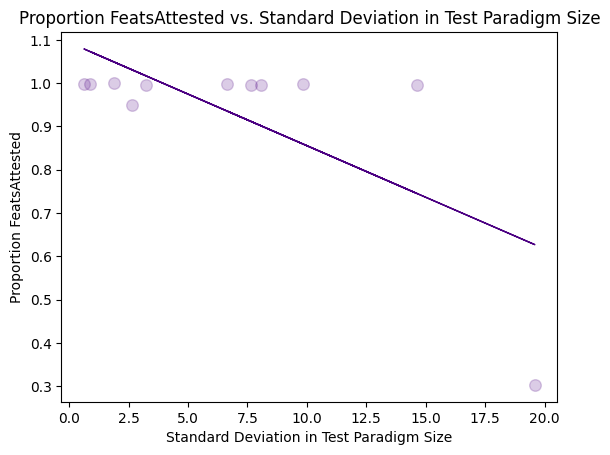

Pearson's R:	-0.690,	 p = 0.01886331616952922
Spearman:	-0.627,	 p = 0.03884525362035334
Kendall's Tau:	-0.418,	 p = 0.08656124739458072


In [11]:
ovlps = []
problematic_percent_increase = []
problematic_stdevs = []
test_stdevs = []

# Iterate through all the languages with less than 100% overlap and store each POS separately 
for ovlp, lang in zip(overlap, languages):
    res = investigate_feature_overlap(f"{PATH_TO_DATA}/{lang}", verbose=False)
    if ovlp < 1: 
        # Store for calculating the averages for each language
        local_percent_increase = []
        local_prob_stdevs = []
        local_test_stdevs = []
        for pos in res:
            if "problematic" in res[pos]:
                # Percent increase in paradigm size 
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                diff = 100 * (test - train) / train 
                local_percent_increase.append(diff)
                # Standard deviation in problematic paradigm size 
                local_prob_stdevs.append(res[pos]["problematic"][1])
            if "test" in res[pos]:
                # Standard deviation in test paradigm size 
                local_test_stdevs.append(res[pos]["test"][1])
                
        # Calculate the averages for each language
        local_percent_increase = np.asarray(local_percent_increase)
        problematic_percent_increase.append(np.mean(local_percent_increase))
        
        local_prob_stdevs = np.asarray(local_prob_stdevs)
        problematic_stdevs.append(np.mean(local_prob_stdevs))
        
        local_test_stdevs = np.asarray(local_test_stdevs)
        test_stdevs.append(np.mean(local_test_stdevs))
        
        ovlps.append(ovlp)

# Plot the percent increase vs. the featureset overlap 
plot_stats(problematic_percent_increase, 
           ovlps, 
           "Percent Increase in Paradigm Size for Problematic Lemmas", 
           "Proportion FeatsAttested")

# Plot the standard deviation vs. the featureset overlap 
plot_stats(problematic_stdevs,
           ovlps, 
           "Standard Deviation in Problematic Lemma Paradigm Size", 
           "Proportion FeatsAttested")

# Plot the standard deviation of the test paradigm size vs. the featureset overlap 
plot_stats(test_stdevs, 
           ovlps, 
           "Standard Deviation in Test Paradigm Size", 
           "Proportion FeatsAttested")    

## Other Potential Effects on Feature Overlap

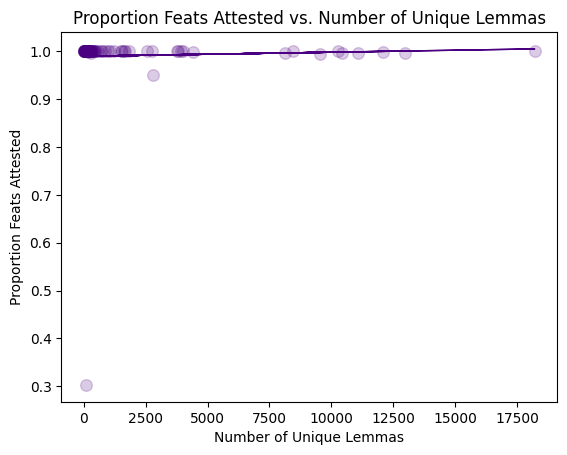

Pearson's R:	0.040,	 p = 0.7107964247186537
Spearman:	-0.381,	 p = 0.00020851753754807926
Kendall's Tau:	-0.303,	 p = 0.00035184363199842615


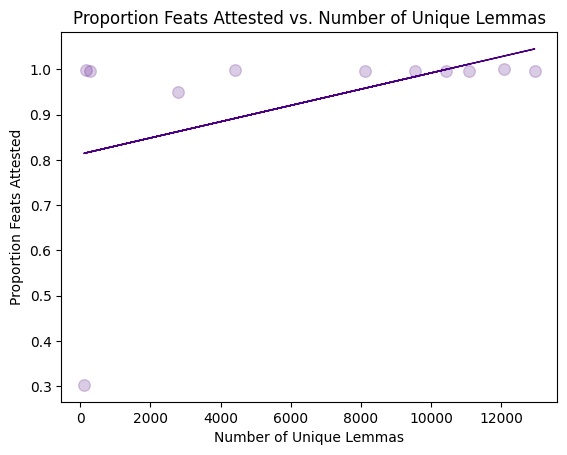

Pearson's R:	0.438,	 p = 0.17797475668016552
Spearman:	0.345,	 p = 0.2980892209030388
Kendall's Tau:	0.236,	 p = 0.3587114698573032


In [13]:
unique_lems, overlap, languages = run_correlation(PATH_TO_DATA, unique_lemmas, feature_overlap)
plot_stats(unique_lems, overlap, "Number of Unique Lemmas", "Proportion Feats Attested")
plot_stats(unique_lems, overlap, "Number of Unique Lemmas", "Proportion Feats Attested", less=True)

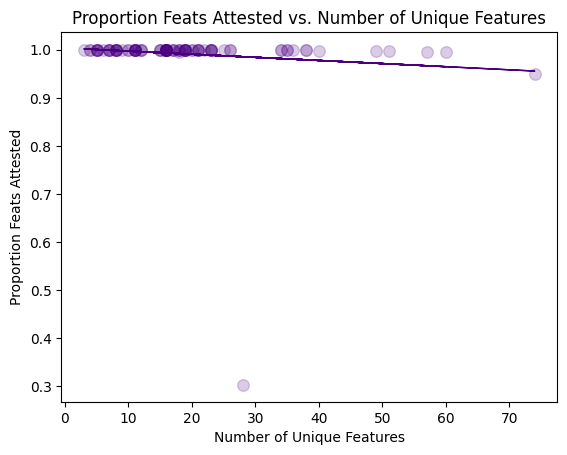

Pearson's R:	-0.114,	 p = 0.28342999161911137
Spearman:	-0.501,	 p = 4.981773409070696e-07
Kendall's Tau:	-0.417,	 p = 1.4042806106518135e-06


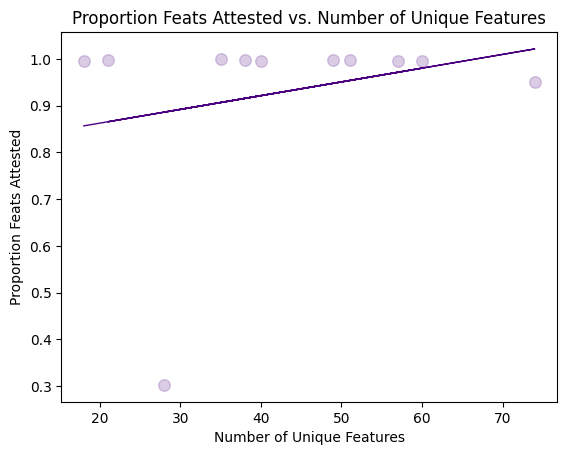

Pearson's R:	0.243,	 p = 0.47103057175725066
Spearman:	-0.291,	 p = 0.38545696969136556
Kendall's Tau:	-0.309,	 p = 0.21834651074234407


In [14]:
unique_fts, overlap, languages = run_correlation(PATH_TO_DATA, unique_features, feature_overlap)
plot_stats(unique_fts, overlap, "Number of Unique Features", "Proportion Feats Attested")
plot_stats(unique_fts, overlap, "Number of Unique Features", "Proportion Feats Attested", less=True)

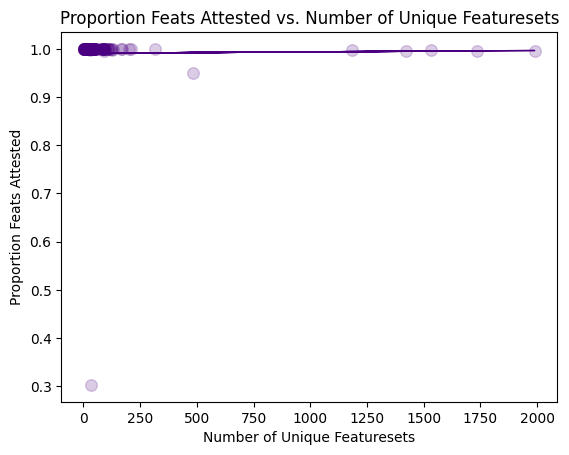

Pearson's R:	0.014,	 p = 0.8955368671130264
Spearman:	-0.422,	 p = 3.374985021539207e-05
Kendall's Tau:	-0.341,	 p = 5.905330822568842e-05


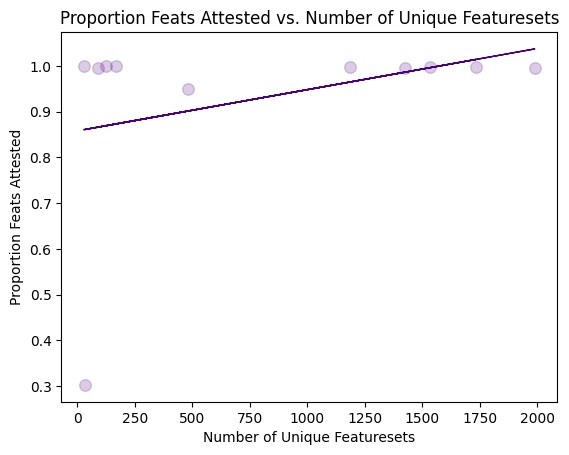

Pearson's R:	0.334,	 p = 0.3146903510562379
Spearman:	-0.109,	 p = 0.7495085962341482
Kendall's Tau:	-0.055,	 p = 0.8792698312489979


In [15]:
unique_ftss, overlap, languages = run_correlation(PATH_TO_DATA, unique_featuresets, feature_overlap)
plot_stats(unique_ftss, overlap, "Number of Unique Featuresets", "Proportion Feats Attested")
plot_stats(unique_ftss, overlap, "Number of Unique Featuresets", "Proportion Feats Attested", less=True)

## Within-Data Relationships

TODO: Check how these all correlate with training size as well 

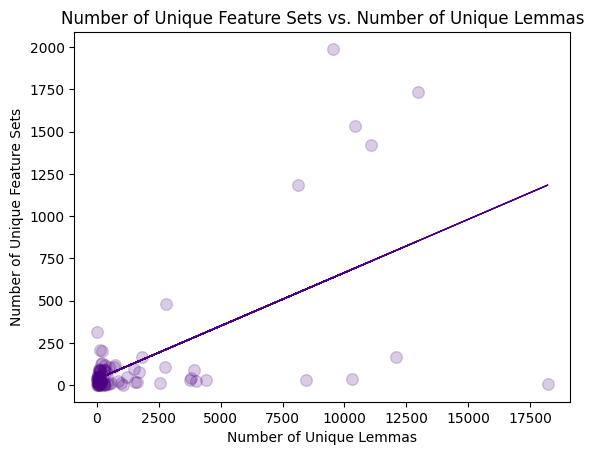

Pearson's R:	0.606,	 p = 2.4014812041671446e-10
Spearman:	0.274,	 p = 0.00907795261075298
Kendall's Tau:	0.201,	 p = 0.005225968592352


In [16]:
lemmas, features, languages = run_correlation(PATH_TO_DATA, unique_lemmas, unique_featuresets)
plot_stats(lemmas, features, "Number of Unique Lemmas", "Number of Unique Feature Sets")

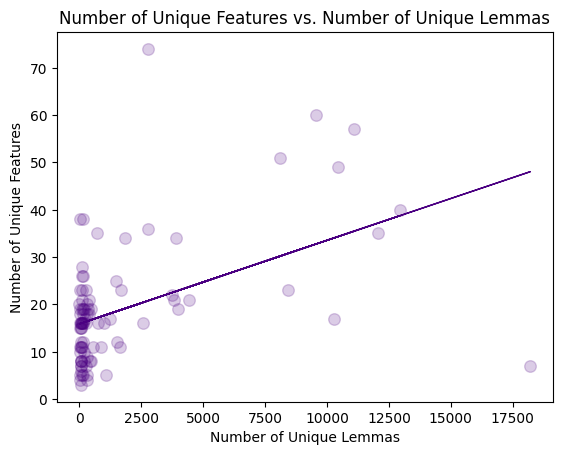

Pearson's R:	0.473,	 p = 2.4978447316677218e-06
Spearman:	0.399,	 p = 9.60194208143829e-05
Kendall's Tau:	0.289,	 p = 7.98082887089737e-05


In [17]:
lemmas, features, languages = run_correlation(PATH_TO_DATA, unique_lemmas, unique_features)
plot_stats(lemmas, features, "Number of Unique Lemmas", "Number of Unique Features")

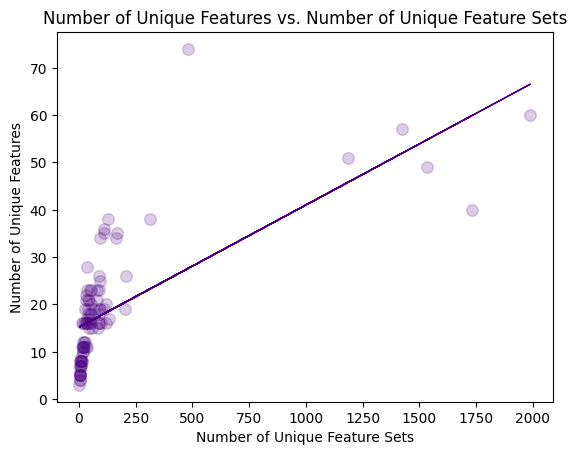

Pearson's R:	0.719,	 p = 1.4560429587787492e-15
Spearman:	0.867,	 p = 2.1661677218065572e-28
Kendall's Tau:	0.726,	 p = 4.7381303534837157e-23


In [18]:
feature_sets, features, languages = run_correlation(PATH_TO_DATA, unique_featuresets, unique_features)
plot_stats(feature_sets, features, "Number of Unique Feature Sets", "Number of Unique Features")

Mean percent increase in training size: -2.789
Standard deviation in training size: 6.155


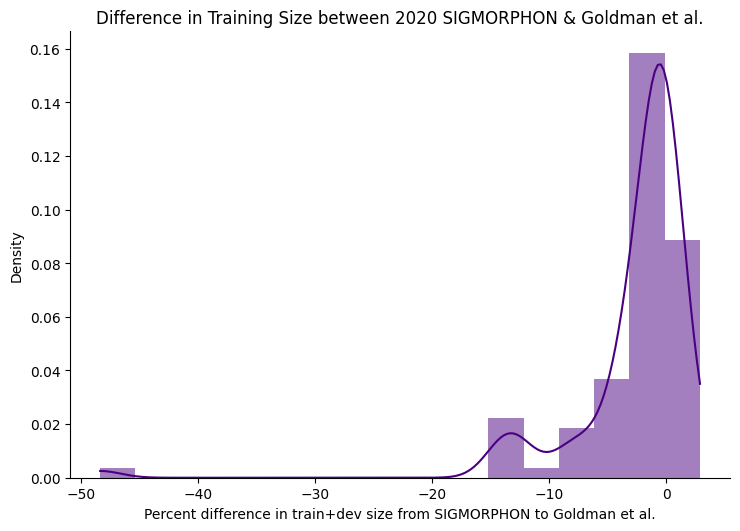

In [44]:
PATH_TO_GOLDMAN_DATA = "LemmaSplitting/LemmaSplitData"
goldman_dict = {}

PATH_TO_SIGMORPHON = "SIGMORPHON2020/train"
sigmorphon_dict = {}

for f in [f for f in os.listdir(PATH_TO_GOLDMAN_DATA) if "." not in f]:
    for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_GOLDMAN_DATA}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_GOLDMAN_DATA}/{f}/{lang}")
        goldman_dict[lang] = len(train) + len(dev)


for f in [f for f in os.listdir(PATH_TO_SIGMORPHON) if "." not in f]:
     for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_SIGMORPHON}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_SIGMORPHON}/{f}/{lang}")
        sigmorphon_dict[lang] = len(train) + len(dev)
        
differences = []
        
for lang in goldman_dict: 
    g = goldman_dict[lang]
    s = sigmorphon_dict[lang]
    percent_diff = 100 * (g - s) / s
    differences.append(percent_diff)

differences = np.asarray(differences)
print(f"Mean percent increase in training size: {np.mean(differences) :.3f}")
print(f"Standard deviation in training size: {np.std(differences) :.3f}")

sns.displot(differences,
            color="indigo",
            linewidth=0,
            alpha=0.5,
            kde=True,
            binwidth = 3,
            kde_kws = {"bw_adjust": 0.7},
            stat="density",
            aspect=1.5,
           )

plt.xlabel("Percent difference in train+dev size from SIGMORPHON to Goldman et al.")
plt.title("Difference in Training Size between 2020 SIGMORPHON & Goldman et al.")
plt.savefig("../writeup/figs/training_difference.png", dpi=500, bbox_inches='tight')

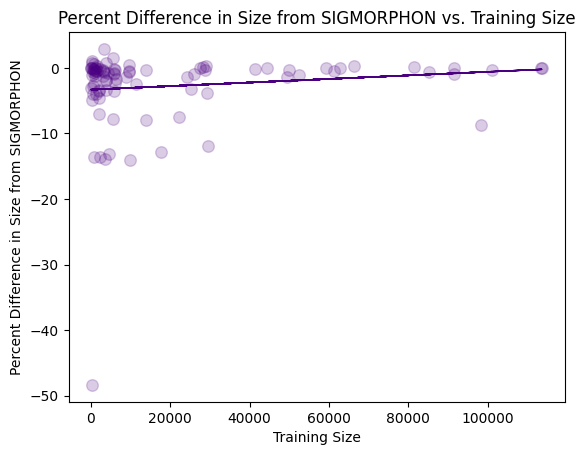

Pearson's R:	0.130,	 p = 0.22212332068735094
Spearman:	0.080,	 p = 0.455978010324126
Kendall's Tau:	0.057,	 p = 0.4288309373434457


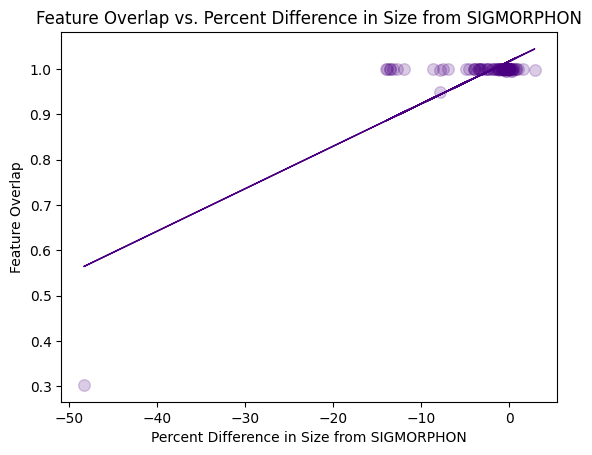

Pearson's R:	0.789,	 p = 2.802446933871228e-20
Spearman:	0.006,	 p = 0.9536993238739178
Kendall's Tau:	0.003,	 p = 0.9706108804980467


In [52]:
trn_sz, overlap, languages = run_correlation(PATH_TO_DATA, train_size, feature_overlap)

differences = []

for lang in languages:
    lang = lang.split("/")[-1]
    g = goldman_dict[lang]
    s = sigmorphon_dict[lang]
    percent_diff = 100 * (g - s) / s
    differences.append(percent_diff)
    
plot_stats(trn_sz, differences, "Training Size", "Percent Difference in Size from SIGMORPHON")

plot_stats(differences, overlap, "Percent Difference in Size from SIGMORPHON", "Feature Overlap")